In [1]:
%reset -f

In [2]:
from datasets import load_dataset, DatasetDict
from transformers import ViTForImageClassification, ViTFeatureExtractor, DefaultDataCollator
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

dataset_dir = "/home/clap/Documents/miniproject_bioinformatic/dataset/dataset_beans_split/sample_500" #load from env parameter
beans_dataset = load_dataset("imagefolder", data_dir=dataset_dir)

/home/clap/Documents/www/bean-leaf-classification-transformer/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


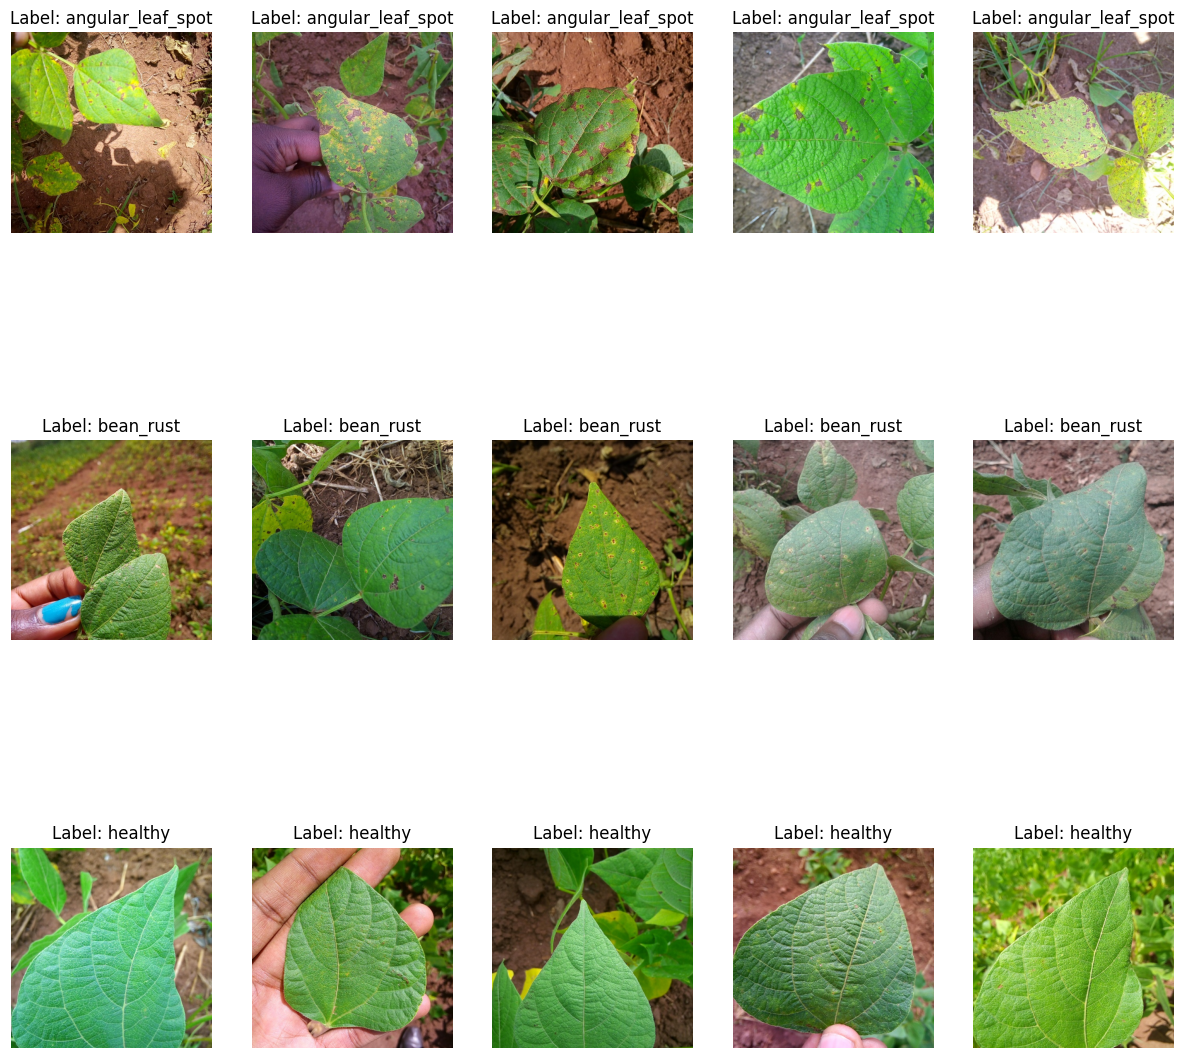

In [3]:
import matplotlib.pyplot as plt
# Function to display images with labels
def show_images_with_labels(dataset, num_images=5):
    ds_features = dataset.features
    fig, axes = plt.subplots(3, num_images, figsize=(15, 15))
    for index_label in range(3):
        label_dataset = dataset.filter(lambda example: example['label'] == index_label)
        for j, example in enumerate(label_dataset.select(range(num_images))):
            image = example['image']
            label = example['label']
            label = ds_features['label'].int2str(label)
            axes[index_label, j].imshow(image)
            axes[index_label, j].set_title(f"Label: {label}")
            axes[index_label, j].axis('off')
    plt.show()

show_images_with_labels(beans_dataset['train'])

In [4]:
# Preprocess data using ViTFeatureExtractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

def preprocess_data(examples):
    # Extract pixel values and normalize images
    images = [image for image in examples["image"]]
    inputs = feature_extractor(images=images, return_tensors="np")
    examples["pixel_values"] = inputs["pixel_values"]
    return examples

# Apply preprocessing to train and test splits
beans_data = beans_dataset.map(preprocess_data, batched=True)

# Remove unused columns and set format for PyTorch
beans_data = beans_data.remove_columns(["image"])
beans_data.set_format("torch", columns=["pixel_values", "label"])



/home/clap/Documents/www/bean-leaf-classification-transformer/.venv/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [5]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=3,  # Beans dataset has 3 classes
    id2label={0: "angular_leaf_spot", 1: "bean_rust", 2: "healthy"},
    label2id={"angular_leaf_spot": 0, "bean_rust": 1, "healthy": 2},
     ignore_mismatched_sizes=True  
)
# Define training arguments
training_args = TrainingArguments(
    output_dir="./vit-beans",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    logging_dir="./logs",
    logging_steps=10,
    num_train_epochs=15,

)


# Data collator for padding
data_collator = DefaultDataCollator()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/clap/Documents/www/bean-leaf-classification-transformer/.venv/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [6]:
# Define metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import EarlyStoppingCallback


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=beans_data["train"],
    eval_dataset=beans_data["validation"],
    tokenizer=feature_extractor,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
   callbacks=[EarlyStoppingCallback(early_stopping_patience=4)]  #
)

# Train the model
trainer.train()

# Evaluate on test set
test_results = trainer.evaluate(eval_dataset=beans_data["test"])
print(f"Test Results: {test_results}")

/tmp/ipykernel_144334/3063431320.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  2%|▏         | 10/480 [00:34<26:37,  3.40s/it]

{'loss': 0.9651, 'grad_norm': 6.9109416007995605, 'learning_rate': 1.9583333333333333e-05, 'epoch': 0.31}


  4%|▍         | 20/480 [01:09<27:13,  3.55s/it]

{'loss': 0.6585, 'grad_norm': 5.505423545837402, 'learning_rate': 1.916666666666667e-05, 'epoch': 0.62}


  6%|▋         | 30/480 [01:46<27:30,  3.67s/it]

{'loss': 0.4039, 'grad_norm': 3.9944920539855957, 'learning_rate': 1.8750000000000002e-05, 'epoch': 0.94}


                                                
  7%|▋         | 32/480 [02:01<20:55,  2.80s/it]

{'eval_loss': 0.3069642186164856, 'eval_accuracy': 0.924812030075188, 'eval_precision': 0.9264619883040935, 'eval_recall': 0.924812030075188, 'eval_f1': 0.9245980378378245, 'eval_runtime': 10.7369, 'eval_samples_per_second': 12.387, 'eval_steps_per_second': 0.838, 'epoch': 1.0}


  8%|▊         | 40/480 [02:32<29:36,  4.04s/it]

{'loss': 0.3, 'grad_norm': 3.3853530883789062, 'learning_rate': 1.8333333333333333e-05, 'epoch': 1.25}


 10%|█         | 50/480 [03:10<27:00,  3.77s/it]

{'loss': 0.1448, 'grad_norm': 2.0872931480407715, 'learning_rate': 1.7916666666666667e-05, 'epoch': 1.56}


 12%|█▎        | 60/480 [03:48<26:55,  3.85s/it]

{'loss': 0.1303, 'grad_norm': 2.6963531970977783, 'learning_rate': 1.7500000000000002e-05, 'epoch': 1.88}


                                                
 13%|█▎        | 64/480 [04:12<20:08,  2.90s/it]

{'eval_loss': 0.13082674145698547, 'eval_accuracy': 0.9548872180451128, 'eval_precision': 0.9601946041574524, 'eval_recall': 0.9548872180451128, 'eval_f1': 0.9551214320595839, 'eval_runtime': 10.9444, 'eval_samples_per_second': 12.152, 'eval_steps_per_second': 0.822, 'epoch': 2.0}


 15%|█▍        | 70/480 [04:36<30:28,  4.46s/it]

{'loss': 0.0801, 'grad_norm': 0.47721049189567566, 'learning_rate': 1.7083333333333333e-05, 'epoch': 2.19}


 17%|█▋        | 80/480 [05:15<26:37,  3.99s/it]

{'loss': 0.0303, 'grad_norm': 2.4271531105041504, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.5}


 19%|█▉        | 90/480 [05:55<26:00,  4.00s/it]

{'loss': 0.029, 'grad_norm': 0.26217204332351685, 'learning_rate': 1.6250000000000002e-05, 'epoch': 2.81}


                                                
 20%|██        | 96/480 [06:27<19:02,  2.97s/it]

{'eval_loss': 0.07284082472324371, 'eval_accuracy': 0.9849624060150376, 'eval_precision': 0.9856162144491664, 'eval_recall': 0.9849624060150376, 'eval_f1': 0.984958608642819, 'eval_runtime': 11.1453, 'eval_samples_per_second': 11.933, 'eval_steps_per_second': 0.808, 'epoch': 3.0}


 21%|██        | 100/480 [06:43<31:03,  4.90s/it]

{'loss': 0.0281, 'grad_norm': 0.31871169805526733, 'learning_rate': 1.5833333333333333e-05, 'epoch': 3.12}


 23%|██▎       | 110/480 [07:23<24:58,  4.05s/it]

{'loss': 0.0106, 'grad_norm': 0.1362811177968979, 'learning_rate': 1.5416666666666668e-05, 'epoch': 3.44}


 25%|██▌       | 120/480 [08:04<24:09,  4.03s/it]

{'loss': 0.0058, 'grad_norm': 0.24315249919891357, 'learning_rate': 1.5000000000000002e-05, 'epoch': 3.75}


                                                 
 27%|██▋       | 128/480 [08:43<17:21,  2.96s/it]

{'eval_loss': 0.043297719210386276, 'eval_accuracy': 0.9774436090225563, 'eval_precision': 0.9775956574956096, 'eval_recall': 0.9774436090225563, 'eval_f1': 0.9774379108058134, 'eval_runtime': 10.9817, 'eval_samples_per_second': 12.111, 'eval_steps_per_second': 0.82, 'epoch': 4.0}


 27%|██▋       | 130/480 [08:52<34:41,  5.95s/it]

{'loss': 0.0035, 'grad_norm': 0.05155130848288536, 'learning_rate': 1.4583333333333333e-05, 'epoch': 4.06}


 29%|██▉       | 140/480 [09:31<22:38,  3.99s/it]

{'loss': 0.0033, 'grad_norm': 0.05099340155720711, 'learning_rate': 1.416666666666667e-05, 'epoch': 4.38}


 31%|███▏      | 150/480 [10:11<21:50,  3.97s/it]

{'loss': 0.0027, 'grad_norm': 0.058750469237565994, 'learning_rate': 1.375e-05, 'epoch': 4.69}


 33%|███▎      | 160/480 [10:46<15:19,  2.87s/it]

{'loss': 0.0028, 'grad_norm': 0.07767361402511597, 'learning_rate': 1.3333333333333333e-05, 'epoch': 5.0}


                                                 
 33%|███▎      | 160/480 [10:57<15:19,  2.87s/it]

{'eval_loss': 0.05863586440682411, 'eval_accuracy': 0.9774436090225563, 'eval_precision': 0.9788533834586466, 'eval_recall': 0.9774436090225563, 'eval_f1': 0.9774093678218316, 'eval_runtime': 10.7954, 'eval_samples_per_second': 12.32, 'eval_steps_per_second': 0.834, 'epoch': 5.0}


 35%|███▌      | 170/480 [11:37<21:01,  4.07s/it]

{'loss': 0.0023, 'grad_norm': 0.03442039340734482, 'learning_rate': 1.2916666666666668e-05, 'epoch': 5.31}


 38%|███▊      | 180/480 [12:16<19:50,  3.97s/it]

{'loss': 0.0018, 'grad_norm': 0.044222936034202576, 'learning_rate': 1.25e-05, 'epoch': 5.62}


 40%|███▉      | 190/480 [12:56<19:00,  3.93s/it]

{'loss': 0.0018, 'grad_norm': 0.05206507071852684, 'learning_rate': 1.2083333333333333e-05, 'epoch': 5.94}


                                                 
 40%|████      | 192/480 [13:11<14:03,  2.93s/it]

{'eval_loss': 0.048448432236909866, 'eval_accuracy': 0.9699248120300752, 'eval_precision': 0.9705266205026242, 'eval_recall': 0.9699248120300752, 'eval_f1': 0.9699020047591173, 'eval_runtime': 10.7793, 'eval_samples_per_second': 12.338, 'eval_steps_per_second': 0.835, 'epoch': 6.0}


 42%|████▏     | 200/480 [13:43<19:16,  4.13s/it]

{'loss': 0.0014, 'grad_norm': 0.036167778074741364, 'learning_rate': 1.1666666666666668e-05, 'epoch': 6.25}


 44%|████▍     | 210/480 [14:22<17:37,  3.92s/it]

{'loss': 0.0016, 'grad_norm': 0.03407199680805206, 'learning_rate': 1.125e-05, 'epoch': 6.56}


 46%|████▌     | 220/480 [15:02<17:23,  4.01s/it]

{'loss': 0.0013, 'grad_norm': 0.027547748759388924, 'learning_rate': 1.0833333333333334e-05, 'epoch': 6.88}


                                                 
 47%|████▋     | 224/480 [15:25<12:29,  2.93s/it]

{'eval_loss': 0.04397659748792648, 'eval_accuracy': 0.9699248120300752, 'eval_precision': 0.9705266205026242, 'eval_recall': 0.9699248120300752, 'eval_f1': 0.9699020047591173, 'eval_runtime': 10.896, 'eval_samples_per_second': 12.206, 'eval_steps_per_second': 0.826, 'epoch': 7.0}


 48%|████▊     | 230/480 [15:49<18:14,  4.38s/it]

{'loss': 0.0014, 'grad_norm': 0.03599262610077858, 'learning_rate': 1.0416666666666668e-05, 'epoch': 7.19}


 50%|█████     | 240/480 [16:29<15:58,  3.99s/it]

{'loss': 0.0012, 'grad_norm': 0.0240671094506979, 'learning_rate': 1e-05, 'epoch': 7.5}


 52%|█████▏    | 250/480 [17:08<15:12,  3.97s/it]

{'loss': 0.0013, 'grad_norm': 0.024908090010285378, 'learning_rate': 9.583333333333335e-06, 'epoch': 7.81}


                                                 
 53%|█████▎    | 256/480 [17:39<11:05,  2.97s/it]

{'eval_loss': 0.04460049420595169, 'eval_accuracy': 0.9699248120300752, 'eval_precision': 0.9705266205026242, 'eval_recall': 0.9699248120300752, 'eval_f1': 0.9699020047591173, 'eval_runtime': 10.9793, 'eval_samples_per_second': 12.114, 'eval_steps_per_second': 0.82, 'epoch': 8.0}


 53%|█████▎    | 256/480 [17:40<15:28,  4.14s/it]


{'train_runtime': 1060.6316, 'train_samples_per_second': 7.043, 'train_steps_per_second': 0.453, 'train_loss': 0.10990039525495376, 'epoch': 8.0}


100%|██████████| 8/8 [00:09<00:00,  1.16s/it]

Test Results: {'eval_loss': 0.08158764988183975, 'eval_accuracy': 0.9453125, 'eval_precision': 0.9461433531746032, 'eval_recall': 0.9453125, 'eval_f1': 0.9454764160250627, 'eval_runtime': 10.7306, 'eval_samples_per_second': 11.928, 'eval_steps_per_second': 0.746, 'epoch': 8.0}


In [7]:
from sklearn.metrics import precision_recall_fscore_support

# Run predictions on the test set
predictions = trainer.predict(beans_data["test"])

# Get the true labels and predicted labels
true_labels = predictions.label_ids
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

100%|██████████| 8/8 [00:09<00:00,  1.14s/it]

Accuracy: 0.95
Precision: 0.95
Recall: 0.95
F1 Score: 0.95


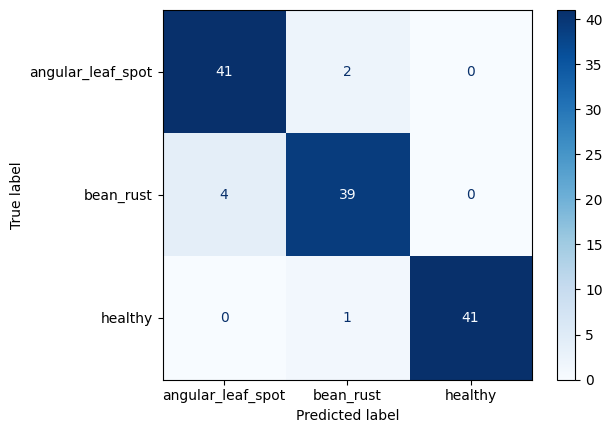

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt


# Get the true labels and predicted labels
true_labels = predictions.label_ids
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["angular_leaf_spot", "bean_rust", "healthy"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [9]:
print(model)


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe